# Kenya Sign Language Finger Spelling Detection

## 1. Business Understanding

### (a) Introduction

In a world where effective communication is the cornerstone of social interaction,there exist significant challenges for individuals with disabilities,particularly those who rely on sign language as their primary means of communication. Communication is not just a basic human right but also a fundamental requirement for participation in society,accessing essential services,and enjoying a high quality of life.

Finger Spelling is a crucial form of communication for individuals with hearing impairments.It involves using handshapes to spell out words and convey messages,making it an essential component of sign language and augmenting other communication methods.For many Deaf and Hard of Hearing individuals,fingerspelling is not just a mode of communication;it is a vital tool for expressing thoughts,emotions and ideas effectively.Despite its significance, there exist a stark communication gap between individuals who rely on fingerspelling and the boarder society.This gap often leads to social isolation,limited access to education and employment opportunities, and barriers to accessing essential services. Bridging this divide is not just a matter of convinience, its a matter of fundamental human rights and social justice.

Recognizing this, the Ministry of Public Services,Gender,Senior Citizens Affairs, and the special Program and Rehabilitative Services Division has embarked on a transformative initiative to break down the barriers faced by individuals with this kind of disability.This division focuses on providing support and services to individuals with special needs. It often encompasses services for people with disabilities, including rehabilitation,vocational training and programs aimed at improving their quality of life.

Our project will harness the power of advanced computer vision techniques to detect and interpret the intricate handshapes and movements that constitute fingerspelling.By doing so in real time, we aim to create a system that can facilitate immediate, meaningful communication between individuals with disabilities and their conterparts.Our vision is to develop an innovative solution that leverages modern technology to empower Deaf and Hard of Hearing individuals by enabling real-time fingerspelling interpretation. This project will improve the ministry's ability to provide services to individuals with disabilities,especially those who rely on fingerspelling.This will enable more effective communication between the government officials and citizens with disabilities,enhancing the quality and accessibility of services.


### (b) The Problem Statement

Effective communication is a fundamental human right and an essential component of social inclusion and participation. However individuals with hearing impairments who rely on fingerspelling as their primary means of communication face often significant communication barriers.The problem at hand is limited accessibility and inclusivity faced by individuals with hearing impairments who rely on fingerspelling.Current communication solutions do not adequately facilitate effective communication between individuals proficient in this visual-gesture language. The Ministry of Public Services,Gender, Senior Citizens Affairs and Special Program and Rehabilitative Services Division have commissioned this project to develop and implement a real-time fingerspelling detection system that can bridge the communication gap between individuals with hearing impairments to communicate effectively with the government officials,access government services, education, and employment opportunities and promote their overall social inclusion and well-being.

### (c) Defining a Metric of Success

- **Recognition Accuracy**

Achieve a recognition accuracy rate of at least 90%, measured by the percentage of correctly identified fingerspelled words out of the total fingerspelled words processed by the system.

- **Response Time**

Ensure a response time of less than 20 seconds for recognizing and translating fingerspelling gestures into text or speech in real-time.

- **Error Rate**

Maintain a low error rate, with recognition errors accounting for less than 5% of total interactions with the system.

- **Intergration success**

Intergrate the system successully into a website,ensuring seamless functionality.

### (d) The Main Objective

To develop and implement a real-time fingerspelling detection system that empowers individuals with hearing impairments to communicate effectively with the broader community,government officials and service providers,thereby promoting inclusivity,accessibility and social intergration.

### (e) Specific Objectives

- **Data Collection**

Collect a diverse and comprehensive dataset of fingerspelling gestures performed by individuals with varying signing styles,hand shapes and speeds and merge it with the already existing kaggle dataset.

- **Develop a robust hand detection system**

Create an accurate and robust hand detection system using cvzone and MediaPipe to ensure precise tracking of hand movements during fingerspelling.

- **Implement fingerspelling recognition**

Develop a recogntion component that can identify and interpret fingerspelled gestures in real-time using machine learning algorithms.

- **Real-time translation**

Intergrate a translation mechanism that converts detected fingerspelled letters into text in real-time,ensuring immediate and accessible communication.

- **User-Friendly Interface**

Design an intuitive user interface that is accessible and user-friendly, allowing individuals with disabilities to interact with the system comfortably

- **Intergration into a website**

Develop a website to intergrate the system to maximize its reach and impact.

### (f) Data Understanding

## 2.  Importing Libraries


In [48]:
#importing necessary libraries
import cv2
import os
import joblib
import skimage
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array
from keras import layers, initializers, optimizers, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping



# Setting a random seed
np.random.seed(180)

plt.style.use("ggplot")

## 3. Collecting data

In [ ]:
# cap = cv2.VideoCapture(0)
# detector = HandDetector(maxHands=1)

# offset = 20
# imgSize = 300

# folder = 'Data/A'
# counter = 0

# while True:
#     success, img = cap.read()
#     hands, img = detector.findHands(img)
#     if hands:
#         hand = hands[0]
#         x, y, w, h = hand['bbox']

#         imgwhite = np.ones((imgSize, imgSize, 3), np.uint8)*255

#         imgCrop =img[y-offset:y + h+offset, x-offset:x + w+offset]

#         imgCropShape = imgCrop.shape

        

#         aspectRatio = h/w
#         if aspectRatio > 1:
#             k = imgSize/h
#             wCal = math.ceil(k*w)
#             imgResize = cv2.resize(imgCrop, (wCal, imgSize))
#             imgResizeShape = imgResize.shape
#             wGap = math.ceil(imgSize-wCal)/2
#             imgwhite[:, int(wGap) : int(wCal) + int(wGap)] = imgResize

#         else:
#             k = imgSize/w
#             hCal = math.ceil(k*h)
#             imgResize = cv2.resize(imgCrop, (imgSize, hCal))

#             imgResizeShape = imgResize.shape
#             hGap = math.ceil((imgSize-hCal)/2)
#             imgwhite[int(hGap) : int(hCal) + int(hGap), :] = imgResize


#         cv2.imshow('ImageCrop', imgCrop)
#         cv2.imshow('ImageWhite', imgwhite)

#     cv2.imshow('Image', img)
#     key = cv2.waitKey(10)
#     if key == ord('s'):
#         counter += 1
#         cv2.imwrite(f'{folder}/Image_{time.time()}.jpg', imgwhite)
#         print(counter)


## 4. Reading the Data

In [2]:
# Reading train and test dataset
train = pd.read_csv("sign_mnist_train.csv")
test = pd.read_csv("sign_mnist_test.csv")

# printing first five rows of the train data
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


The dataset appears to be a collection of images that have been flattened and converted into a tabular format.

The dataset is structured as a table with 785 columns. Each row in the table represents an image.

The first column, ‘label’, represents the class or category of each image. In the context of hand gestures, each unique number could represent a specific gesture.

The remaining 784 columns represent individual pixel values of each image. Given there are 784 pixels, it suggests that each original image was a 28x28 pixel grayscale image. Each pixel column in the table corresponds to a specific pixel in the image grid.

The values in the pixel columns range from 0 to 255, representing the grayscale intensity at that specific pixel (0 being black and 255 being white).


In [3]:
# a class to decribe the dataset
class Describer:

    #initialize an object
    def __init__(self, df):
        self.df = df

    #checking the shape of the data
    def shape(self, name):
        return print(f"The {name} dataset has {self.df.shape[0]} entries and {self.df.shape[1]} columns")

In [4]:
#Viewing the shape of the train dataset
data = Describer(train)
data.shape("train")

The train dataset has 27455 entries and 785 columns


In [5]:
#Viewing the shape of the test dataset
data = Describer(test)
data.shape("test")

The test dataset has 7172 entries and 785 columns


In [6]:
# Displaying the column names
train.columns

Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=785)

In [7]:
# reading the collected raw images
train_generator = ImageDataGenerator().flow_from_directory("Images", target_size=(28,28),
                                                           batch_size=3000)

Found 2445 images belonging to 24 classes.


The data we collected is stored in an Image folder. There are 2445 images belonging to 24 classes

In [8]:
#Getting all images and labels
train_images, train_labels = next(train_generator)

In [9]:
#Flattening images into lists of pixels
images_list = []
for img_array in train_images:
    gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
    gray = np.expand_dims(gray, 2)
    images_list.append(gray.reshape(-1, 784).flatten().tolist())

In [10]:
#converting the images to a DataFrame
raw_img_df = pd.DataFrame(images_list)
raw_img_df.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,255.0,255.0,254.41301,255.0,146.244995,147.875000,147.277008,152.337006,151.109009,154.119995,...,126.717995,127.276993,131.091995,132.234009,132.244995,254.472992,255.000000,255.0,255.0,255.0
1,255.0,255.0,255.00000,255.0,255.000000,255.000000,255.000000,255.000000,254.885986,150.245010,...,125.244995,254.472992,254.402008,255.000000,255.000000,255.000000,255.000000,255.0,255.0,255.0
2,255.0,255.0,255.00000,255.0,255.000000,255.000000,255.000000,255.000000,254.885986,150.234009,...,130.000000,254.000000,254.885986,255.000000,255.000000,255.000000,255.000000,255.0,255.0,255.0
3,255.0,255.0,255.00000,255.0,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,254.413010,255.000000,255.000000,255.000000,254.885986,255.0,255.0,255.0
4,255.0,255.0,255.00000,255.0,254.885986,142.472992,143.244995,144.233994,146.875000,147.875000,...,119.875000,118.234001,122.234001,118.875008,253.874985,255.000000,254.000000,255.0,255.0,255.0


In [11]:
# Generating the labels
train_labels = pd.Series([np.argmax(label)
                           for label in train_labels])

In [12]:
# Concatenating the labels and the raw picture dataframe
raw_df = pd.concat([train_labels, raw_img_df], axis=1)
raw_df.columns = train.columns

#Displaying the first 5 rows of the raw images dataframe
raw_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,11,255.0,255.0,254.41301,255.0,146.244995,147.875000,147.277008,152.337006,151.109009,...,126.717995,127.276993,131.091995,132.234009,132.244995,254.472992,255.000000,255.0,255.0,255.0
1,3,255.0,255.0,255.00000,255.0,255.000000,255.000000,255.000000,255.000000,254.885986,...,125.244995,254.472992,254.402008,255.000000,255.000000,255.000000,255.000000,255.0,255.0,255.0
2,5,255.0,255.0,255.00000,255.0,255.000000,255.000000,255.000000,255.000000,254.885986,...,130.000000,254.000000,254.885986,255.000000,255.000000,255.000000,255.000000,255.0,255.0,255.0
3,14,255.0,255.0,255.00000,255.0,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,254.413010,255.000000,255.000000,255.000000,254.885986,255.0,255.0,255.0
4,21,255.0,255.0,255.00000,255.0,254.885986,142.472992,143.244995,144.233994,146.875000,...,119.875000,118.234001,122.234001,118.875008,253.874985,255.000000,254.000000,255.0,255.0,255.0


In [13]:
#splitting the raw df to train and test dataframes
train_df, test_df = train_test_split(raw_df, test_size=0.1, random_state=180)

#### Combining Datasets
The kaggle dataset labels are from 0-24 with 9 and 25 missing which represent the j and z letters that have been excluded but the raw dataset labels are from 0-23. For the two datasets to be merged, the labels should be similar.

In [14]:
# mapping the labels into correct labels
mapping_dict = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 10: 9, 11: 10,
                12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19,
                21: 20, 22: 21, 23: 22, 24: 23}

train["label"] = train["label"].map(mapping_dict)
test["label"] = test["label"].map(mapping_dict)

In [15]:
# Concatenating the collected images and the train dataset
train = pd.concat([train, train_df])
train.reset_index(drop=True, inplace=True)

# Displaying the first five rows
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107.0,118.0,127.0,134.0,139.0,143.0,146.0,150.0,153.0,...,207.0,207.0,207.0,207.0,206.0,206.0,206.0,204.0,203.0,202.0
1,6,155.0,157.0,156.0,156.0,156.0,157.0,156.0,158.0,158.0,...,69.0,149.0,128.0,87.0,94.0,163.0,175.0,103.0,135.0,149.0
2,2,187.0,188.0,188.0,187.0,187.0,186.0,187.0,188.0,187.0,...,202.0,201.0,200.0,199.0,198.0,199.0,198.0,195.0,194.0,195.0
3,2,211.0,211.0,212.0,212.0,211.0,210.0,211.0,210.0,210.0,...,235.0,234.0,233.0,231.0,230.0,226.0,225.0,222.0,229.0,163.0
4,12,164.0,167.0,170.0,172.0,176.0,179.0,180.0,184.0,185.0,...,92.0,105.0,105.0,108.0,133.0,163.0,157.0,163.0,164.0,179.0


The kaggle and our data are combined to increasing the chances of making a robust model that can generalize better to unseen data.Combining the datasets also increases the data volume allowing the models to learn from a larger variety of examples

## 4. Exploratory data Analysis

- **Displaying Images**

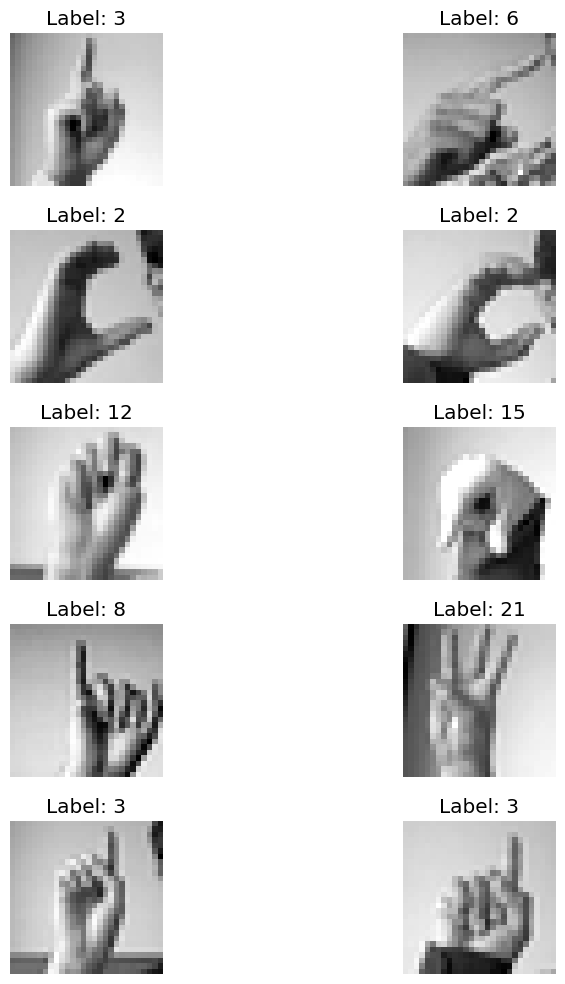

In [16]:
#displaying first 10 images
# Extract pixel values and labels
pixel_columns = train.columns[1:]
pixel_values = train[pixel_columns].values
labels = train['label'].values

# Display images
fig, axes = plt.subplots(5, 2, figsize=(8, 10))
fig.tight_layout()


for i in range(10):
    row = i // 2
    col = i % 2
    pixel_array = pixel_values[i].reshape(28, 28)
    # Display image on the corresponding subplot
    axes[row, col].imshow(pixel_array, cmap='gray')
    axes[row, col].set_title('Label: ' + str(labels[i]))
    axes[row, col].axis('off')

# Show the plot
plt.show()

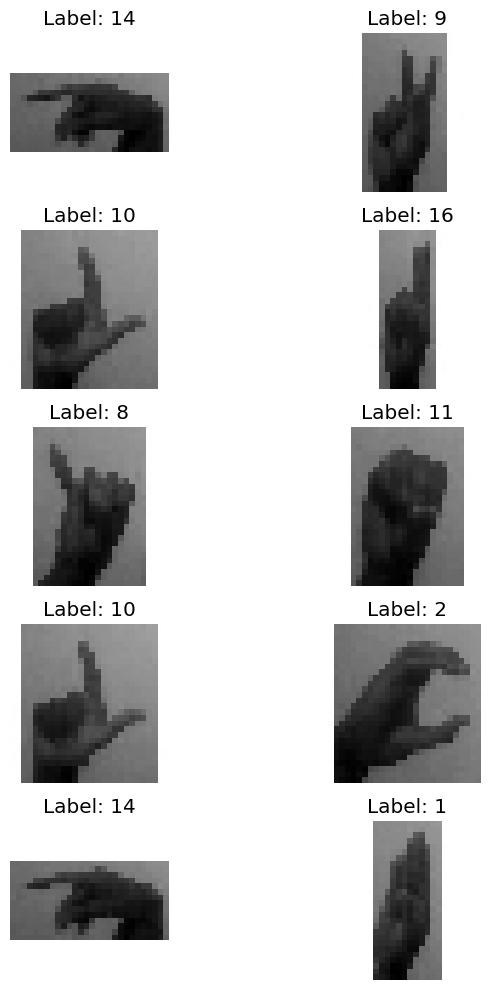

In [17]:
# Displaying the last 10 images
pixel_columns = train.columns[1:]
pixel_values = train[pixel_columns].values
labels = train['label'].values

# Get the last 10 images
last_10_images = pixel_values[-10:]
last_10_labels = labels[-10:]

# Create subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(8, 10))

# Display images
for i, ax in enumerate(axes.flat):
    pixel_array = last_10_images[i].reshape(28, 28)
    ax.imshow(pixel_array, cmap='gray')
    ax.set_title('Label: ' + str(last_10_labels[i]))
    ax.axis('off')

plt.tight_layout()
plt.show()

- **Checking Frequency Distribution in the sets**

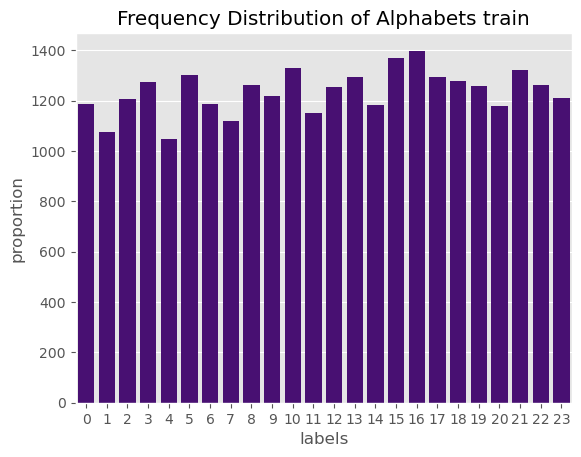

In [24]:
# Distribution of the labels column train dataset
def check_distribution(data, col, name):
  sns.countplot(data=data, x=col, color="indigo")
  plt.xlabel('labels')
  plt.ylabel('proportion')
  plt.title(f"Frequency Distribution of Alphabets {(name)}")
  plt.show();

check_distribution(train, 'label', "train")

In the analysis conducted, it was found that the label column exhibits a fairly distributed class distribution with no notable class imbalances. All classes display similar proportions, indicating a well-balanced dataset. This characteristic ensures that the model will have an equal opportunity to learn from and make accurate predictions across all classes.

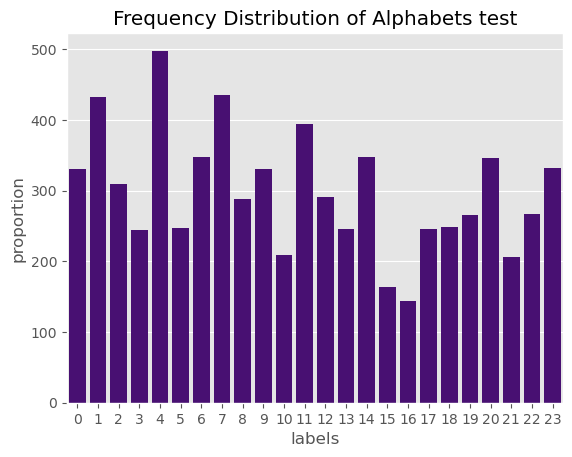

In [25]:
# Distribution of the labels column test dataset
check_distribution(test, 'label', "test")

The test dataset displays quite a bit of class imbalance which will help reflect the real-world distribution of the data that the model will encounter when its deployed.

- **Checking Pixel Distribution**

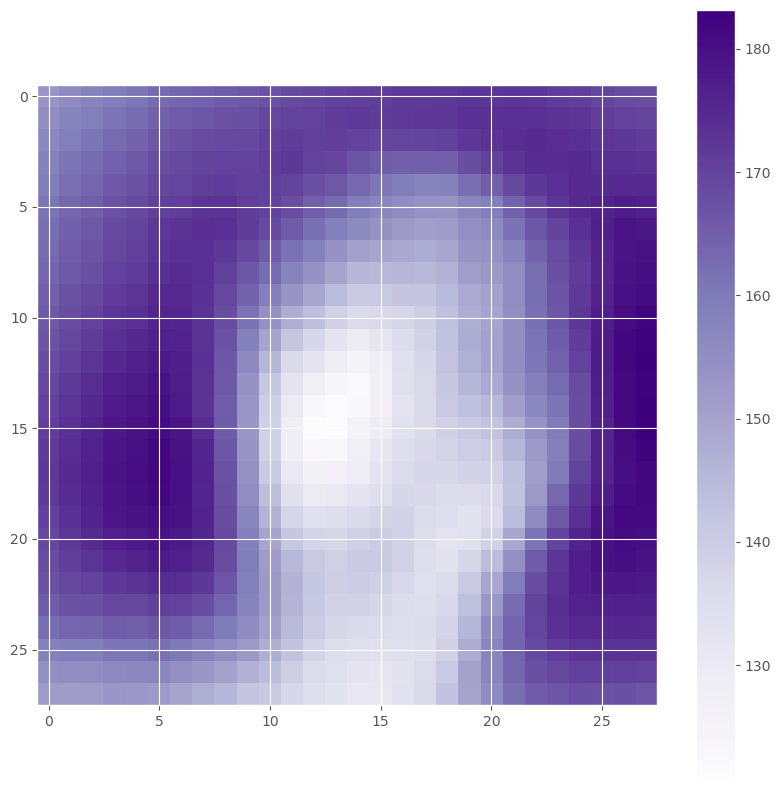

In [50]:
pixel_columns = [col for col in train.columns if col != 'label']
images = train[pixel_columns].to_numpy()

# Reshape the images
# Assuming the images are 28x28 pixels
images = images.reshape(-1, 28, 28)

# Calculate the average image
average_image = np.mean(images, axis=0)

# Plot the average image as a heatmap
plt.figure(figsize=(10,10))
plt.imshow(average_image, cmap='Purples')  # 'PuRd' is a colormap that ranges from purple to red
plt.colorbar()
plt.show()

From this heatmap, it appears that the images have higher pixel values around the edges, particularly in the top left and bottom right corners. The center of the images tends to have lower pixel values. This suggests that the hand gestures in the images might be generally centered and surrounded by a darker background.

## 5.Modelling

**Preprocessing Images**

In [26]:
# Splitting the train and test datasets
train_X = train.iloc[:, 1:]
train_y = train.label

test_X = test.iloc[:, 1:]
test_y = test.label

In [27]:
#onehot encoding the train and test labels
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

In [28]:
# Normalizing our train and test data
train_X /= 255
test_X /= 255

In [29]:
train_X_reshaped = np.array(train_X).reshape(-1, 28, 28, 1)
test_X_reshaped = np.array(test_X).reshape(-1, 28, 28, 1)

In [30]:
#Preprocessing the images
def preprocess_images(images):
    preprocessed_images = []
    for image in images:
        image = skimage.filters.gaussian(image, sigma=1)
        image = skimage.exposure.equalize_hist(image)
        # blurred = cv2.GaussianBlur(image, (3,3), 0)
        preprocessed_images.append(image)
    return np.array(preprocessed_images).reshape(-1, 28, 28, 1)


train_X_reshaped = preprocess_images(train_X_reshaped)
test_X_reshaped = preprocess_images(test_X_reshaped)

c:\New folder\envs\learn-env\lib\site-packages\skimage\_shared\utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


#### (i)  The Baseline Model

In [31]:
# two layers baseline model
baseline_model = Sequential()
baseline_model.add(layers.Dense(64, activation="relu", input_shape=(784,)))
baseline_model.add(layers.Dense(32, activation="relu"))
baseline_model.add(layers.Dense(24, activation="softmax"))

#compiling our model
baseline_model.compile(loss="categorical_crossentropy",
                       optimizer="sgd",
                       metrics=["accuracy"])

#fitting the model
baseline_history = baseline_model.fit(train_X, train_y,
                                      epochs=100, batch_size=100,
                                      validation_split=0.2)

print("Baseline model test data accuracy: ")
baseline_model.evaluate(test_X, test_y)

Epoch 1/100
238/238 [==============================] - 4s 7ms/step - loss: 3.1013 - accuracy: 0.0931 - val_loss: 3.0938 - val_accuracy: 0.0821
Epoch 2/100
238/238 [==============================] - 1s 5ms/step - loss: 2.9471 - accuracy: 0.1633 - val_loss: 3.0226 - val_accuracy: 0.1374
Epoch 3/100
238/238 [==============================] - 1s 5ms/step - loss: 2.7169 - accuracy: 0.2655 - val_loss: 3.0048 - val_accuracy: 0.1907
Epoch 4/100
238/238 [==============================] - 1s 5ms/step - loss: 2.4299 - accuracy: 0.3389 - val_loss: 3.1822 - val_accuracy: 0.2570
Epoch 5/100
238/238 [==============================] - 1s 5ms/step - loss: 2.1736 - accuracy: 0.3937 - val_loss: 3.4284 - val_accuracy: 0.2408
Epoch 6/100
238/238 [==============================] - 1s 5ms/step - loss: 1.9656 - accuracy: 0.4436 - val_loss: 3.5016 - val_accuracy: 0.3077
Epoch 7/100
238/238 [==============================] - 1s 5ms/step - loss: 1.7955 - accuracy: 0.4810 - val_loss: 3.4140 - val_accuracy: 0.3011

[1.3516888618469238, 0.6965978741645813]

The model consists of two hidden layers and an output layer.

The first hidden layer has 64 neurons and uses the ReLU (Rectified Linear Unit) activation function.
The second hidden layer has 32 neurons and also uses the ReLU activation function.
The output layer has 24 neurons (which should correspond to the number of classes in your data) and uses the softmax activation function to output a probability distribution over the classes.
The model is compiled with the categorical cross-entropy loss function, the stochastic gradient descent (SGD) optimizer, and accuracy as the evaluation metric.

The model is trained for 100 epochs with a batch size of 100. During training, 20% of the training data is used as a validation set.

From the output, it appears that the model’s training accuracy increases over time, reaching almost 100% by the 100th epoch. This suggests that the model is fitting the training data well. However, the validation accuracy is much lower and seems to decrease after a certain point. This suggests that the model may be overfitting the training data - it’s learning the training data very well but failing to generalize to unseen data.

The model is evaluated on the test set, achieving an accuracy of approximately 69.66%.



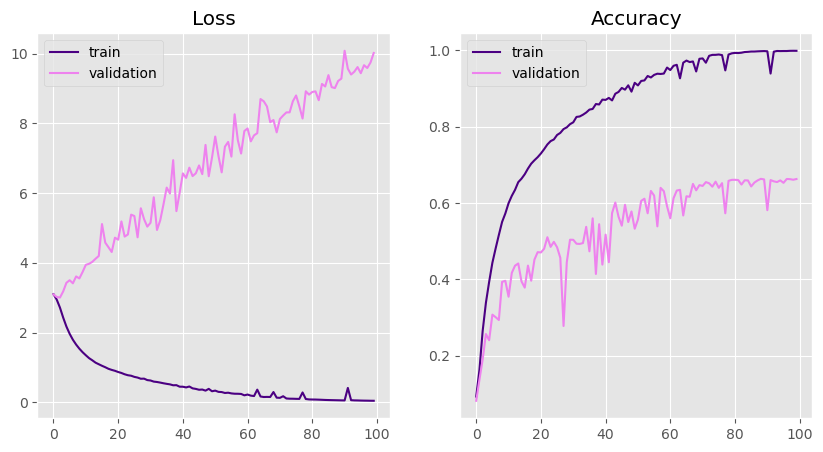

In [33]:
#Plotting the loss and accuracy of the test and validation datasets
def plot_loss_and_accuracy(results, final=False):

    if final:
        val_label="test"
    else:
        val_label="validation"

    # Extracting metrics from model fitting
    train_loss = results.history['loss']
    val_loss = results.history['val_loss']
    train_accuracy = results.history['accuracy']
    val_accuracy = results.history['val_accuracy']

    # Setting up plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Plotting loss info
    ax1.set_title("Loss")
    sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label="train",color="indigo")
    sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label=val_label,color="violet")
    ax1.legend()

    # Plotting accuracy info
    ax2.set_title("Accuracy")
    sns.lineplot(x=results.epoch, y=train_accuracy, ax=ax2, label="train",color="indigo")
    sns.lineplot(x=results.epoch, y=val_accuracy, ax=ax2, label=val_label,color="violet")
    ax2.legend()

#baseline model loss and accuracy
plot_loss_and_accuracy(baseline_history)

The training loss decreases steadily over time, indicating that the model is learning from the training data. However, the validation loss initially decreases but then starts to increase after a certain point. This is a classic sign of overfitting: while the model is becoming better at fitting the training data, it’s performance on unseen data is deteriorating.

The graph on the right shows the model’s accuracy over time. Again, the purple line represents training accuracy and the pink line represents validation accuracy. The training accuracy increases steadily and reaches near 100%, but the validation accuracy plateaus and even slightly decreases after a certain point. This further supports the observation of overfitting.

#### (ii) The Second Model

In [34]:

# converting dataframes to NumPy arrays
train_X_np = train_X.to_numpy()
test_X_np = test_X.to_numpy()

# Reshape your data to (28, 28, 1)
train_X_reshaped = train_X_np.reshape(-1, 28, 28, 1)
test_X_reshaped = test_X_np.reshape(-1, 28, 28, 1)

# Create a Sequential model
cnn_model = Sequential()

# Add Convolutional layers
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

# Flatten the output from the Convolutional layers
cnn_model.add(Flatten())

# Add fully connected layers
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))  # Add dropout for regularization
cnn_model.add(Dense(24, activation='softmax'))  # Adjust the output layer to match your number of classes

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = cnn_model.fit(train_X_reshaped, train_y, epochs=10, batch_size=100, validation_split=0.2)

# Evaluate the model on test data
test_loss, test_accuracy = cnn_model.evaluate(test_X_reshaped, test_y)
print(f'Test accuracy: {test_accuracy}')


Epoch 1/10
238/238 [==============================] - 24s 93ms/step - loss: 1.9676 - accuracy: 0.4031 - val_loss: 2.2550 - val_accuracy: 0.6058
Epoch 2/10
238/238 [==============================] - 21s 89ms/step - loss: 0.7312 - accuracy: 0.7561 - val_loss: 2.2911 - val_accuracy: 0.6594
Epoch 3/10
238/238 [==============================] - 21s 86ms/step - loss: 0.4105 - accuracy: 0.8626 - val_loss: 2.8366 - val_accuracy: 0.6791
Epoch 4/10
238/238 [==============================] - 19s 78ms/step - loss: 0.2581 - accuracy: 0.9141 - val_loss: 3.0849 - val_accuracy: 0.6857
Epoch 5/10
238/238 [==============================] - 19s 79ms/step - loss: 0.1786 - accuracy: 0.9414 - val_loss: 3.1105 - val_accuracy: 0.6928
Epoch 6/10
238/238 [==============================] - 18s 77ms/step - loss: 0.1334 - accuracy: 0.9548 - val_loss: 3.2589 - val_accuracy: 0.6918
Epoch 7/10
238/238 [==============================] - 19s 78ms/step - loss: 0.1041 - accuracy: 0.9667 - val_loss: 3.6646 - val_accuracy:

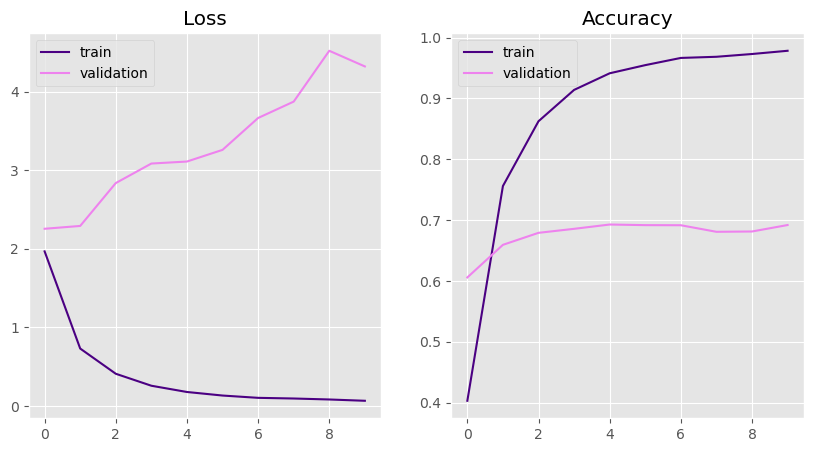

In [35]:

# Define the function to plot loss and accuracy
def plot_loss_and_accuracy(results, final=False):
    if final:
        val_label = "test"
    else:
        val_label = "validation"

    # Extracting metrics from model fitting
    train_loss = results.history['loss']
    val_loss = results.history['val_loss']
    train_accuracy = results.history['accuracy']
    val_accuracy = results.history['val_accuracy']

    # Setting up plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Plotting loss info
    ax1.set_title("Loss")
    sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label="train",color="indigo")
    sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label=val_label,color="violet")
    ax1.legend()

    # Plotting accuracy info
    ax2.set_title("Accuracy")
    sns.lineplot(x=results.epoch, y=train_accuracy, ax=ax2, label="train",color="indigo")
    sns.lineplot(x=results.epoch, y=val_accuracy, ax=ax2, label=val_label,color="violet")
    ax2.legend()

# Assuming you have 'history' from your model training
plot_loss_and_accuracy(history)
plt.show()


In [36]:


# Create a Sequential model
better_cnn_model = Sequential()

# Add Convolutional layers with Batch Normalization and Leaky ReLU activation
better_cnn_model.add(Conv2D(64, (3, 3), activation='linear', input_shape=(28, 28, 1)))
better_cnn_model.add(LeakyReLU(alpha=0.1))
better_cnn_model.add(MaxPooling2D((2, 2)))
better_cnn_model.add(BatchNormalization())

better_cnn_model.add(Conv2D(128, (3, 3), activation='linear'))
better_cnn_model.add(LeakyReLU(alpha=0.1))
better_cnn_model.add(MaxPooling2D((2, 2)))
better_cnn_model.add(BatchNormalization())

# Flatten the output from the Convolutional layers
better_cnn_model.add(Flatten())

# Add fully connected layers with Dropout
better_cnn_model.add(Dense(256, activation='linear'))
better_cnn_model.add(LeakyReLU(alpha=0.1))
better_cnn_model.add(Dropout(0.5))
better_cnn_model.add(Dense(128, activation='linear'))
better_cnn_model.add(LeakyReLU(alpha=0.1))

# Output layer with softmax activation
better_cnn_model.add(Dense(24, activation='softmax'))

# Compile the model
better_cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
better_history = better_cnn_model.fit(train_X_reshaped, train_y, epochs=10, batch_size=128, validation_split=0.2)

# Evaluate the model on test data
test_loss, test_accuracy = better_cnn_model.evaluate(test_X_reshaped, test_y)
print(f'Test accuracy: {test_accuracy}')


Epoch 1/10
186/186 [==============================] - 68s 343ms/step - loss: 0.4622 - accuracy: 0.8599 - val_loss: 5.5310 - val_accuracy: 0.0813
Epoch 2/10
186/186 [==============================] - 53s 286ms/step - loss: 0.0221 - accuracy: 0.9944 - val_loss: 6.7427 - val_accuracy: 0.1216
Epoch 3/10
186/186 [==============================] - 42s 227ms/step - loss: 0.0141 - accuracy: 0.9962 - val_loss: 2.6366 - val_accuracy: 0.6211
Epoch 4/10
186/186 [==============================] - 41s 223ms/step - loss: 0.0126 - accuracy: 0.9965 - val_loss: 3.7721 - val_accuracy: 0.6894
Epoch 5/10
186/186 [==============================] - 42s 224ms/step - loss: 0.0189 - accuracy: 0.9932 - val_loss: 5.3315 - val_accuracy: 0.7021
Epoch 6/10
186/186 [==============================] - 41s 222ms/step - loss: 0.0165 - accuracy: 0.9946 - val_loss: 4.8203 - val_accuracy: 0.6850
Epoch 7/10
186/186 [==============================] - 41s 221ms/step - loss: 0.0196 - accuracy: 0.9938 - val_loss: 5.1860 - val_ac

Baseline Model Evaluation:
Loss: 1.3517, Accuracy: 0.6966

Baseline CNN Model Evaluation:
Loss: 0.3201, Accuracy: 0.9184

Better CNN Model Evaluation:
Loss: 1.1493, Accuracy: 0.8634


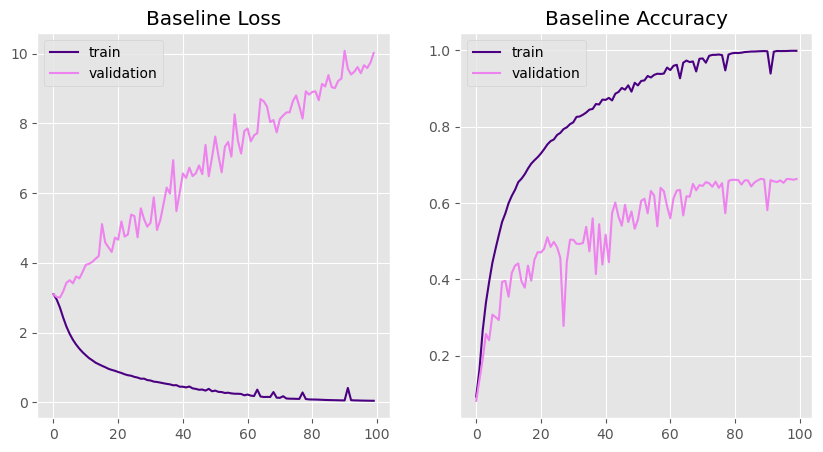

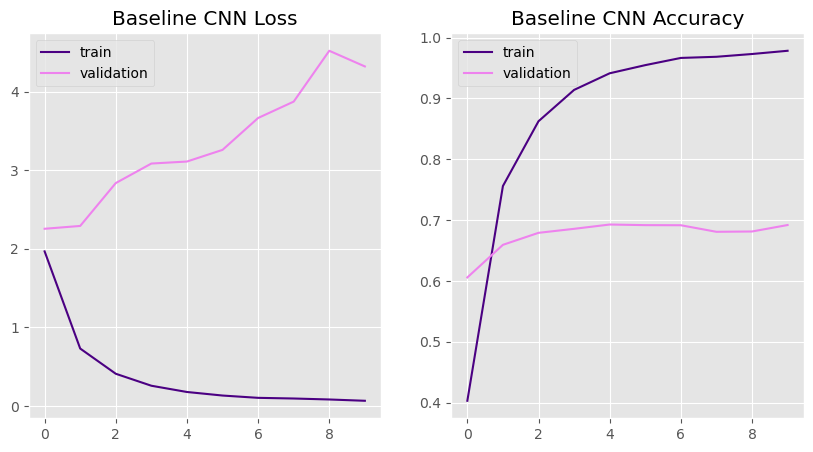

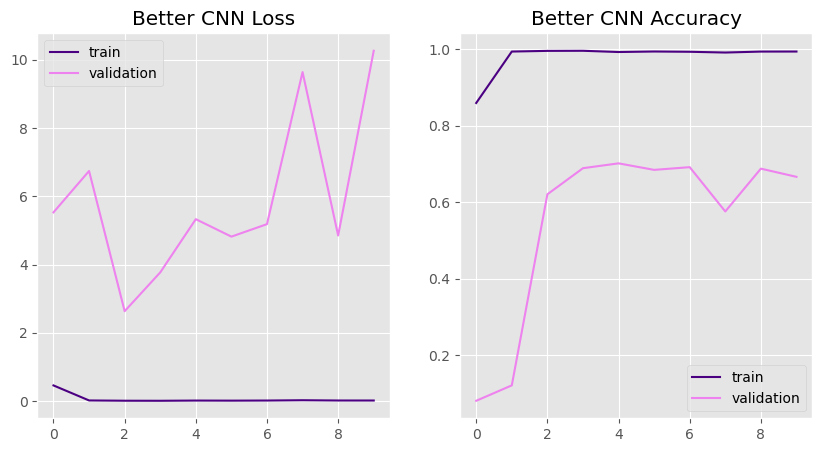

In [37]:

# Plotting the loss and accuracy of the test and validation datasets
def plot_loss_and_accuracy(results, model_name, final=False):
    if final:
        val_label = "test"
    else:
        val_label = "validation"

    # Extracting metrics from model fitting
    train_loss = results.history['loss']
    val_loss = results.history['val_loss']
    train_accuracy = results.history['accuracy']
    val_accuracy = results.history['val_accuracy']

    # Setting up plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Plotting loss info
    ax1.set_title(f"{model_name} Loss")
    sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label="train",color="indigo")
    sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label=val_label,color="violet")
    ax1.legend()

    # Plotting accuracy info
    ax2.set_title(f"{model_name} Accuracy")
    sns.lineplot(x=results.epoch, y=train_accuracy, ax=ax2, label="train",color="indigo")
    sns.lineplot(x=results.epoch, y=val_accuracy, ax=ax2, label=val_label,color="violet")
    ax2.legend()

# Evaluate the models
baseline_eval = baseline_model.evaluate(test_X, test_y, verbose=0)
cnn_eval = cnn_model.evaluate(test_X_reshaped, test_y, verbose=0)
better_cnn_eval = better_cnn_model.evaluate(test_X_reshaped, test_y, verbose=0)

# Display the evaluation results
print("Baseline Model Evaluation:")
print(f"Loss: {baseline_eval[0]:.4f}, Accuracy: {baseline_eval[1]:.4f}")

print("\nBaseline CNN Model Evaluation:")
print(f"Loss: {cnn_eval[0]:.4f}, Accuracy: {cnn_eval[1]:.4f}")

print("\nBetter CNN Model Evaluation:")
print(f"Loss: {better_cnn_eval[0]:.4f}, Accuracy: {better_cnn_eval[1]:.4f}")

# Plot loss and accuracy for all models
plot_loss_and_accuracy(baseline_history, "Baseline")
plot_loss_and_accuracy(history, "Baseline CNN")
plot_loss_and_accuracy(better_history, "Better CNN")
plt.show()


In [38]:
#Making Predictions
predictions = cnn_model.predict(test_X_reshaped)
pred_labels = pd.Series([np.argmax(x) for x in predictions])

225/225 [==============================] - 3s 10ms/step


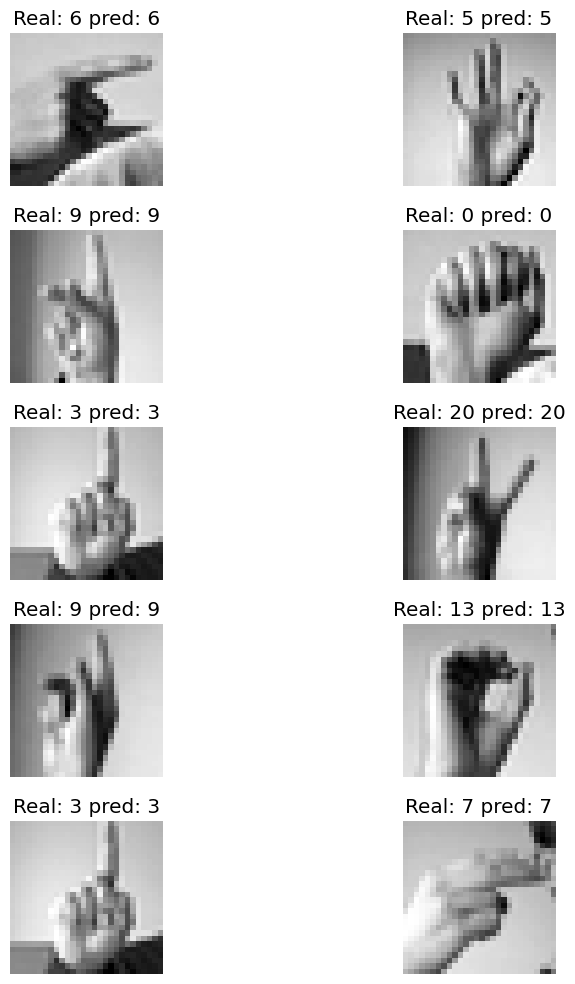

In [39]:
#displaying images
# Extract pixel values and labels
pixel_columns = test.columns[1:]
pixel_values = test[pixel_columns].values
labels = test['label'].values
pred_labels = pred_labels.values

# Display images
fig, axes = plt.subplots(5, 2, figsize=(8, 10))
fig.tight_layout()

# Display images
for i in range(10):
    row = i // 2
    col = i % 2
    pixel_array = pixel_values[i].reshape(28, 28)
    # Display image on the corresponding subplot
    axes[row, col].imshow(pixel_array, cmap='gray')
    axes[row, col].set_title(f"Real: {labels[i]} pred: {pred_labels[i]}")
    axes[row, col].axis('off')

# Show the plot
plt.show()

In [42]:

# Add BatchNormalization layers to your model
cnn_model2 = Sequential()
cnn_model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
cnn_model2.add(BatchNormalization())
cnn_model2.add(MaxPooling2D((2, 2)))
cnn_model2.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model2.add(BatchNormalization())
cnn_model2.add(MaxPooling2D((2, 2)))
cnn_model2.add(Flatten())
cnn_model2.add(Dense(128, activation='relu'))
cnn_model2.add(Dropout(0.5))
cnn_model2.add(Dense(24, activation='softmax'))  # Adjust the output layer to match your number of classes

# Compile the model
cnn_model2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Add an EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train with data augmentation
history = cnn_model2.fit(train_X_reshaped, train_y, batch_size=100,
                        epochs=10,
                        validation_split=0.2,
                        callbacks=[early_stopping])

# Evaluate the model on test data
test_loss, test_accuracy = cnn_model2.evaluate(test_X_reshaped, test_y)
print(f'Test accuracy: {test_accuracy}')

Epoch 1/10
238/238 [==============================] - 36s 137ms/step - loss: 0.8670 - accuracy: 0.7441 - val_loss: 4.3500 - val_accuracy: 0.0664
Epoch 2/10
238/238 [==============================] - 27s 114ms/step - loss: 0.0840 - accuracy: 0.9756 - val_loss: 1.8668 - val_accuracy: 0.5636
Epoch 3/10
238/238 [==============================] - 27s 115ms/step - loss: 0.0403 - accuracy: 0.9880 - val_loss: 1.8477 - val_accuracy: 0.6850
Epoch 4/10
238/238 [==============================] - 27s 115ms/step - loss: 0.0224 - accuracy: 0.9935 - val_loss: 2.9714 - val_accuracy: 0.6741
Epoch 5/10
238/238 [==============================] - 27s 115ms/step - loss: 0.0193 - accuracy: 0.9943 - val_loss: 3.3874 - val_accuracy: 0.7056
Epoch 6/10
225/225 [==============================] - 3s 12ms/step - loss: 0.4933 - accuracy: 0.8749
Test accuracy: 0.8749302625656128


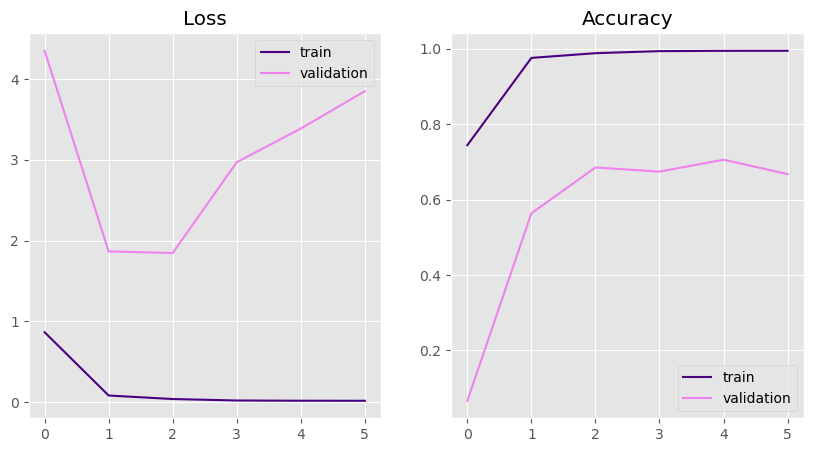

In [47]:

# Define the function to plot loss and accuracy
def plot_loss_and_accuracy(results, final=False):
    if final:
        val_label = "test"
    else:
        val_label = "validation"

    # Extracting metrics from model fitting
    train_loss = results.history['loss']
    val_loss = results.history['val_loss']
    train_accuracy = results.history['accuracy']
    val_accuracy = results.history['val_accuracy']

    # Setting up plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Plotting loss info
    ax1.set_title("Loss")
    sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label="train",color="indigo")
    sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label=val_label,color="violet")
    ax1.legend()

    # Plotting accuracy info
    ax2.set_title("Accuracy")
    sns.lineplot(x=results.epoch, y=train_accuracy, ax=ax2, label="train",color="indigo")
    sns.lineplot(x=results.epoch, y=val_accuracy, ax=ax2, label=val_label,color="violet")
    ax2.legend()

# Assuming you have 'history' from your model training
plot_loss_and_accuracy(history)
plt.show()


In [46]:
#Saving the model
cnn_model.save(r"C:\Users\dell 5450\Documents\Projects\project_deployment\best_model.h5")

C:\Users\dell 5450\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
